In [1]:
from warnings import simplefilter


simplefilter(action="ignore", category=FutureWarning)

from test.helpers import (
    get_mlp_sde,
    SDE,
)

import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, Euler, SaveAt, SpaceTimeTimeLevyArea
from talay import Talay


jax.config.update("jax_enable_x64", True)

t0 = 0.0
t1 = 10.0
saveat = SaveAt(steps=True)
y_dim = 4
mlp_sde: SDE = get_mlp_sde(t0, t1, jnp.float64, jr.key(0), 5, y_dim=y_dim)


def plot_mlp_sde(sol):
    fig, ax = plt.subplots()
    for dim in range(y_dim):
        ax.plot(sol.ts, sol.ys[:, dim], label=f"x_{dim}")

    ax.legend()
    plt.show()


terms_mlp = mlp_sde.get_terms(mlp_sde.get_bm(jr.key(0), SpaceTimeTimeLevyArea, 0.01))

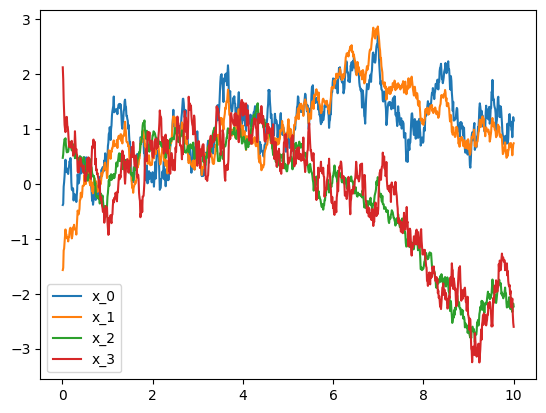

In [2]:
sol_euler = diffeqsolve(
    terms_mlp, Euler(), t0, t1, 0.01, mlp_sde.y0, mlp_sde.args, saveat=saveat
)

plot_mlp_sde(sol_euler)

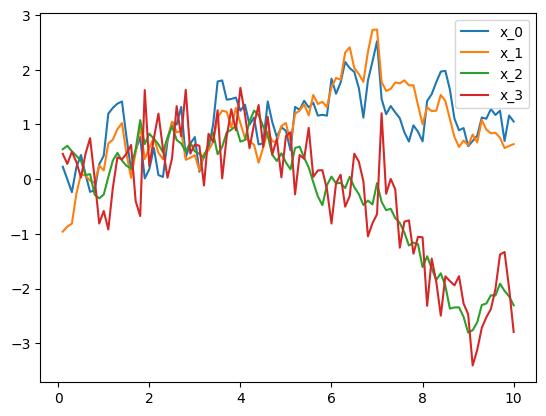

In [14]:
sol_euler_coarse = diffeqsolve(
    terms_mlp, Euler(), t0, t1, 0.1, mlp_sde.y0, mlp_sde.args, saveat=saveat
)

plot_mlp_sde(sol_euler_coarse)

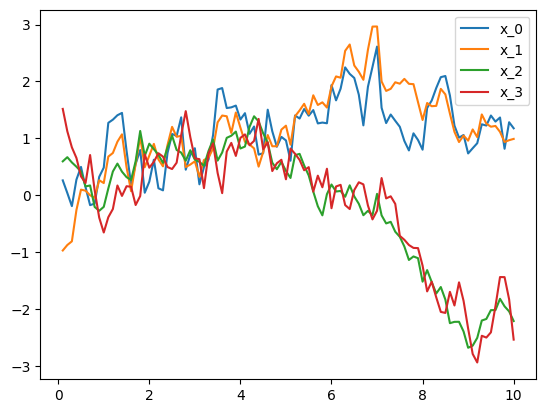

In [15]:
sol_talay_with_levy = diffeqsolve(
    terms_mlp,
    Talay(jr.key(7), use_levy_area=True),
    t0,
    t1,
    0.1,
    mlp_sde.y0,
    mlp_sde.args,
    saveat=saveat,
)

plot_mlp_sde(sol_talay_with_levy)

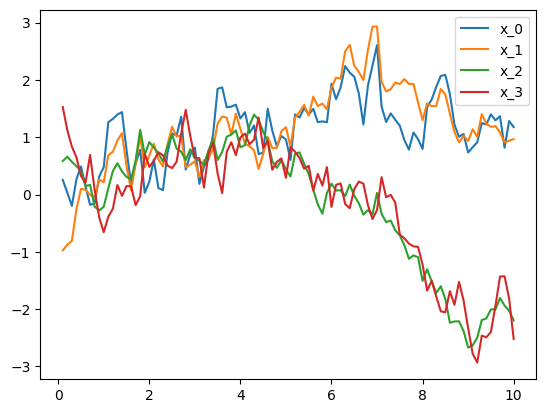

In [16]:
sol_talay_no_levy = diffeqsolve(
    terms_mlp,
    Talay(jr.key(7), use_levy_area=False),
    t0,
    t1,
    0.1,
    mlp_sde.y0,
    mlp_sde.args,
    saveat=saveat,
)

plot_mlp_sde(sol_talay_no_levy)

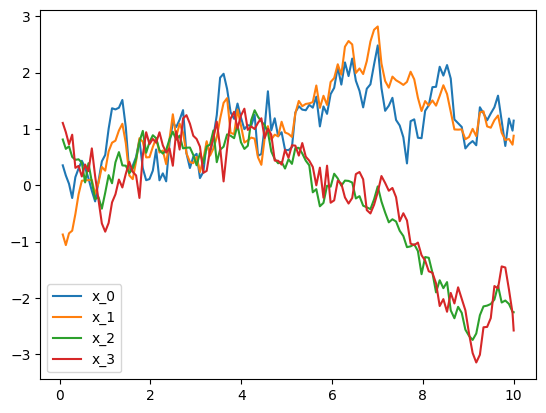

In [17]:
from talay_controller import TalayController


ctol = 2.0

talay_controller = TalayController(ctol=ctol, dtmin=2**-10, dtmax=1.0)

sol_adaptive = diffeqsolve(
    terms_mlp,
    Talay(jr.key(7), error_mult=ctol, use_levy_area=True),
    t0,
    t1,
    None,
    mlp_sde.y0,
    mlp_sde.args,
    saveat=saveat,
    stepsize_controller=talay_controller,
)

plot_mlp_sde(sol_adaptive)